# Projekt "Kamień, Papier, Nożyce"
# Podstawy Reprezentacji i Analizy Danych
# 18.01.2023

**Członkowie zespołu:
Cybulski Dawid,
Petrashevich Ulyana,
Sekula Sebastian**

Projekt polega na stworzeniu algorytmu rozpoznającego gesty w grze "Kamień, Papier, Nożyce"("Rock, Paper, Scissors"). 

Dane wykorzystane do wytrenowania modelu: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?datasetId=107582&sortBy=voteCount.

Do dyspozycji zbiór 2 188 obrazów kolorowych, w tym 712 z gestem "Papier", 726 z gestem "Kamień", 750 z gestem "Nożyce". Rozmiar obrazów: 300x200 pikseli. 

Podjęliśmy decyzję, aby rozwiązać zadanie poprzez model uczenia sieci neuronowych, ponieważ:
1. Sieć może być wykorzystana dla innych danych z podziałem na 3 klasy.
2. Nie musimy przeprowadzać analizy, model sam wyznacza części charakterystyczne.
3. Wyszkolony na dobrych danych jest bardziej odporny na przypadki "niejednoznaczne", np. ręka nie jest widoczna w całości.
4. Mamy dostęp do dużej ilości materiałów pomocniczych.
4. Sztuczna inteligencja jest popularna we współczesnym świecie.

## Implementacja

Wgranie potrzebnych bibliotek

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import os
PATH = os.getcwd()

W tym momencie zaczyna się wczytywanie i dodatkowa modyfikacja danych wejściowych, aby otrzymać dane, które w sposób najkorzystniejszy (to jest przy niedługim czasie, a przy dobrej jakości) pozwolą nam wytrenować model rozpoznawania obrazów. 

Mamy możliwość swoimi oczami przeanalizować dostępne obrazy w folderze. Dlatego wiemy, że większość obrazów mają jednakową postać: ręka jest w środku, dobrze widoczna, prosto do kamery. Ale na niektórych obrazach ręka jest ucięta albo obrócona. Taki zestaw jest dobry dla trenowania, bo nauczy model poprawnie rozpoznawać nie tylko absolutnie przejrzyste przypadki. 

Lecz załóżmy, że dane mogą się zmienić i "nietypowych" obrazków już nie będzie albo nie możemy sprawdzić, czy są. ImageDataGenerator przy wczytaniu losowo wybiera obrazy i przekształca je - zmienia perspektywę, przybliża, odbija, przesuwa i t.p. - znaczy generuje nam właśnie przypadki "nietypowe". 

train_data - instancja generatora obrazów z konkretnymi parametrami (odpowiada za późniejszą obróbkę obrazów). Wartości parametrów zostały podane zgodnie z przykładem na stronie(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator): nie duże i nie małe:
1. **rescale** - po zakończeniu wszystkich przekształceń pomnaża dane przez podaną wartość.
1. **rotation_range** - zakres stopni obrotu losowo wybranego obrazu.
1. **width_shift_range** - zakres przesunięcia poziomowego(w naszym przypadku mierzony w częściach szerokości obrazu) losowo wybranego obrazu.
1. **height_shift_range** - zakres przesunięcia pionowego(w częściach wysokości obrazu) losowo wybranego obrazu.
1. **shear_range** - kąt zmiany perspektywy(w stopniach, w ruchu przeciwnym do wskazówek zegara) losowo wybranego obrazu. Przykład zmiany perspektywy:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Simple_shear_in_2D.svg/1200px-Simple_shear_in_2D.svg.png" style="width:300px" alt="Przykład perspektywy"/>
<strong><center>Źródło: https://en.wikipedia.org/wiki/Shear_force</center></strong>

1. **zoom_range** - zakres przybliżenia(\[1-0.2, 1+0.2\]) losowo wybranego obrazu.
1. **horizontal_flip** - dodaje możliwość poziomego lustrzanego odbicia losowego obrazu.
1. **fill_mode='nearest'** - przy niektórych z przekształceń w obrazie znajdą się dane bez wartości(np. przesunięcie, zmiana perspektywy), dla takich danych przypiszemy wartości komórek znajdujących się najbliżej.
1. **validation_split**- część obrazów, która będzie zarezerwowana jako dane dla sprawdzenia modelu. W naszym przypadku część walidacyjna stanowi 20% wszystkich obrazów. Nie jest to za mało co pomoże dobrze określić poprawność działania modelu, ale też nie jest to za duża ilość co nie ograniczy zdolności poznawczych w trakcie nauki.

train_generator - przy podanej ścieżce do folderu z danymi, pozyskuje je tworząc "batche" (to jest grupy obrazów), które będą wykorzystane do wytrenowania modelu.
1. **directory** - ścieżka do folderu z odpowiednio oznaczonymi obrazami.

1. **class_mode** - argument w swojej domyślnej formie zawierający wartość "categorical" odpowiada to za prawidłowe rozpozanie danych - gdzie dane są poprawnie opisane - już mają swoje etykiety (w naszym przypadku są w odpowiednio nazywanych folderach.

1. **batch_size** - jeśli mówimy o tworzeniu grup obrazów, to można też określić wielkość tych grup i właśnie za to odpowiada owy argument (domyślnie ma wielkość 32).

1. **target_size** - jest to rozmiar, do jakiego będzie sprowadzane wczytane kolejno obrazy.

1. **subset='training'** - wczytuje odpowiednio wcześniej oznaczone dane do treningu.

validation_data - jest instancją generatora obrazów, tym razem z mniejszą ilością parametrów. Jest to potrzebne po to, aby pozyskiwać obrazy w niezmienionej formie, albowiem model będzie rozpoznawał oryginalne obrazy, a nie wstępnie przetworzone - mogłoby to się odbić na poprawności wytrenowanego modelu.

validation_generator - pozyskuje obrazy tworząc "batche", które będą wykorzystane do sprawdzenia poprawności działania modelu.
1. **subset='validation'** - wczytuje odpowiednio wcześniej oznaczone dane do walidacji.

In [3]:
main_dir = "rps-cv-images"
train_data = ImageDataGenerator( rescale = 1.0/255,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest',
                                           validation_split=0.2
                                  )


train_generator = train_data.flow_from_directory(main_dir,
                                                    target_size=(60, 40),
                                                   subset='training')

validation_data = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.2)


validation_generator = validation_data.flow_from_directory(main_dir,
                                                    target_size=(60, 40),
                                                    subset='validation')

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


## Teraz zaczyna się tworzenie splecionej sieci neuronowej.

### Opis działania modelu

Spleciona sieć neuronowa(CNN) działa podobnie do mózgu człowieka - rozpoznaje obiekty na obrazie poprzez rozpoznanie części i relacji pomiędzy nimi. 

1. Część obrazu o rozmiarach, równych rozmiarom filtru, porównuje się z filtrem poprzez sumowanie mnożeń wartości piksela w części obrazu o wartość piksela w filtrze na tym samym miejscu. Dodając stałą "bias term", odpowiadający za przesunięcie krzywej do prawej lub strony, otrzymujemy wynik, który umieszczamy w nowej warstwie. Dalej robimy to samo, ale przesuwamy część obrazu o 1 krok (zazwyczaj 1 piksel). 

<img src="cnn_theory/1.png" alt="CNN porównywanie z filtrem"/>
<strong><center>Źródło: https://youtu.be/HGwBXDKFk9I</center></strong>


2. Otrzymaną warstwę przetwarzamy za pomocą funkcji relu. Ona zapewni, że wszystkie ujemne wartości staną się zerami, dodatnie pozostaną niezmienione.
<img src="cnn_theory/2.png" alt="CNN funkcja relu"/>
<strong><center>Źródło: https://youtu.be/HGwBXDKFk9I</center></strong>


3. Za pomocą nowego filtra (MaxPooling) wyciągamy z oddzielnych części (zwyczajnie o rozmiarach 2x2) warstwy wartości maksymalne i umieszczamy w nowej warstwie. To skutkuje odnalezieniem części obrazów, w których filtr był najbardziej podobny do obrazu.
<img src="cnn_theory/3.png" alt="CNN maxpooling"/>
<strong><center>Źródło: https://youtu.be/HGwBXDKFk9I</center></strong>


4. Spłaszczamy warstwę, otrzymując jednowymiarowy wektor. Warstwa Dense (albo warstwa gęsta) łączy wszystkie swoje neurony z każdą wartością w wektorze. Każde takie połączenie ma swoją wagę. Pomnażając wartość w wektorze o wagę połączenia, sumując wyniki i dodając wartość bias otrzymujemy wynik odpowiadający poziomowi aktywacji neuronu. Funkcja softmax pozwoli na doprowadzenie wartości do postaci, gdzie je summa jest równa 1, pozwalając traktować wartości jako prawdopodobieństwo przynależności obrazu do kategorii.
<img src="cnn_theory/4.png" alt="CNN sieć"/>
<strong><center>Źródło: https://www.databricks.com/glossary/dense-tensor</center></strong>


<img src="cnn_theory/5.png" alt="CNN wynik"/>
<strong><center>Źródło: https://youtu.be/HGwBXDKFk9I</center></strong>


W trakcie trenowania modelu neurony dobierają względem siebie lepsze wagi, aby lepiej rozpoznawać obraz.

### Tworzenie modelu

In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.nn import relu, softmax

Teraz tworzony jest model "Sekwencyjny" - jest to typ modelu, który opiera się o kolejno tworzone warstwy, które w odpowiedni sposób przetwarzają obraz, aby ostatecznie go rozpoznać.

W naszym przypadku model składa się z warstw:

1. **Conv2D** - warstwa odpowiedzialna za wyznaczenie filtrów i sprawdzenie ich dopasowań w całym obrazie.
    1. Pierwszym argumentem jest liczba filtrów, które będą porównywane z częściami obrazu.
    1. Rozmiar filtra.
    1. *activation=relu* - jest to funkcja, która powstałe w macierzy ujemne wyniki zmienia na 0.
    1. *input_shape=(60, 40, 3)* - argument określający rozmiar obrazów przyjmowanych przez warstwę.
    1. *padding='same'* - dodanie tego parametru uzupełnia macierz wejściową zerami na brzegach w taki sposób, aby po nałożeniu na nią filtra, rozmiar macierzy wyjściowej był taki sam jak oryginalny rozmiar macierzy wejściowej (podczas nakładania filtra na macierz tracona jest część informacji, dodawanie zer pozwala tego uniknąć). (https://www.youtube.com/watch?v=PGBop7Ka9AU)

1. **BatchNormalization** - zawęża gamę wejściowych liczb do przedziału <0,1>. Poprawia późniejsze określanie wag neuronów. (https://www.youtube.com/watch?v=yXOMHOpbon8),

1. **MaxPooling2D** - warstwa pozyskująca największe wartości z grup elementów wcześniej powstałej macierzy.

1. **Flatten** - warstwa w oparciu o powstałą macierz tworząca jednowymiarowy wektor.

1. **Dense** - warstwa odpowiedzialna za prawidłowe określanie ważności cech poszczególnych komórek wcześniej powstałej tablicy w celu poprawnej kategoryzacji wczytywanych obiektów.
    1. Pierwszy argument jest długością zwracanej tablicy.
    1. *activation=softmax* - funkcja sprawiająca, że zwracane wartości sumują się do liczby 1. Dzięki temu możemy owe wartości traktować jako prawdopodobieństwo.

In [7]:
model = tf.keras.models.Sequential([
    Conv2D(64, (5,5), activation=relu,input_shape=(60, 40, 3), padding = 'same'),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation=relu,padding = 'same'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation=relu,padding = 'same'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation=relu),
    Dense(3, activation =softmax)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 40, 64)        4864      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 40, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 40, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 20, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 10, 128)     

Aby model nie był zbyt dokładny - rozpoznawał prawidłowo reguły, a nie same obrazy na których był ćwiczony - musimy zmniejszyć tempo uczenia naszego modelu.

In [8]:
from keras.callbacks import ReduceLROnPlateau

Funkcja ReduceLROnPlateau jest rozwiązaniem naszego problemu "zbyt dopasowanego modelu" (https://keras.io/api/callbacks/reduce_lr_on_plateau/). Parametry:

1. **monitor='val_acc'** - ten argument mówi o tym, że w momencie, kiedy metryka poprawności rozpoznawania danych wejściowych nie poprawia się, zmniejszane jest tempo uczenia.

1. **patience=2** - ilość epok, które muszą przejść, aby redukcja tempa uczenia zaczęła być wprowadzana w życie.

1. **verbose=1** - każdy raz przy uruchomieniu zmniejszania tempa będzie wyświetlany odpowiedni komunikat.

1. **factor=0.5** - współczynnik określający zmianę tempa uczenia (nowe_tempo = factor * stare_tempo).

1. **min_lr=0.000003** - dolny limit tempa uczenia - wolniej nie będzie.

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

W tym momencie możemy już się podjąć uczenia naszego modelu.

Metoda "compile" rozpoczyna owy proces. Parametry:

1. **loss**='categorical_crossentropy' - funkcja straty - owa funkcja w oparciu o przewidywaną kategorię dla danego obrazi i obecny wynik kategoryzacji określa jak bardzo dobrze model klasyfikuje obiekty. Im mniejsza wartość owej funkcji, tym model działa lepiej. Jest to miara odchylenia od oczekiwanej wartości. 'categorical_crossentropy' jest typem funkcji wykorzystywanym w procesie obliczania funkcji straty dla modeli, których zadaniem jest określanie kategorii obiektów. Etykiety powstałe w wyniku działania tejże modelu opartym o ową funkcję są zerami lub jedynką, w jasny sposób określając kategorię danego obrazu. (https://gombru.github.io/2018/05/23/cross_entropy_loss/)

1. **optimizer=Adam()** - funkcja optymalizująca model w oparciu o funkcję straty, w sposób taki, aby ta funkcja była jak najmniejsza. Dlaczego Adam? Przez swoją złożoność obliczeniową i małe wymagania pamięciowe jest idealny do pracy ze zbiorami danych o dużej ilości parametrów. (https://www.youtube.com/watch?v=JhQqquVeCE0)

1. **metrics=['accuracy']** - parametr na podstawie którego model będzie się uczył.

Metoda "fit" - trenuje zadany model.

1. Pierwszym argumentem jest zbiór danych testowych.

1. **epochs=15**, oznacza liczbę epok, potrzebnych do wytrenowania modelu.

1. **verbose=1**, pokazuje informacje o postępach treningu.

1. **validation_data** - zbiór danych walidacyjnych.

1. **callbacks=[learning_rate_reduction]** - argument określający, funkcje do których odwołuje się model w trakcie uczenia. W naszym przypadku do funkcji zapobiegającej przetrenowaniu modelu.

*W kodzie inspiracyjnym pominięty był atrybut padding='same' w pierwszej warstwie m modelu co wpływało na pojawienie się błędu o braku pozwolenia na optymalizację poprzez rozszerzenie macierzy o atrybut padding, pozyskanych dalej macierzy przez warstwę Conv2D (zmodyfikowanych przez parametr padding)*

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs = 15,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/15
55/55 [==============================] - 27s 475ms/step - loss: 1.3192 - accuracy: 0.4654 - val_loss: 1.0087 - val_accuracy: 0.4485 - lr: 0.0010
Epoch 2/15
55/55 [==============================] - 26s 462ms/step - loss: 0.6222 - accuracy: 0.7470 - val_loss: 0.8354 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/15
55/55 [==============================] - 27s 483ms/step - loss: 0.4657 - accuracy: 0.8332 - val_loss: 0.5975 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 4/15
55/55 [==============================] - 24s 430ms/step - loss: 0.3311 - accuracy: 0.8789 - val_loss: 0.5643 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 5/15
55/55 [==============================] - 23s 409ms/step - loss: 0.2539 - accuracy: 0.9086 - val_loss: 0.2693 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/15
55/55 [==============================] - 22s 406ms/step - loss: 0.2351 - accuracy: 0.9126 - val_loss: 0.2686 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 7/15
55/55 [==============================] - ETA: 0s - lo

## Wyniki działania modelu

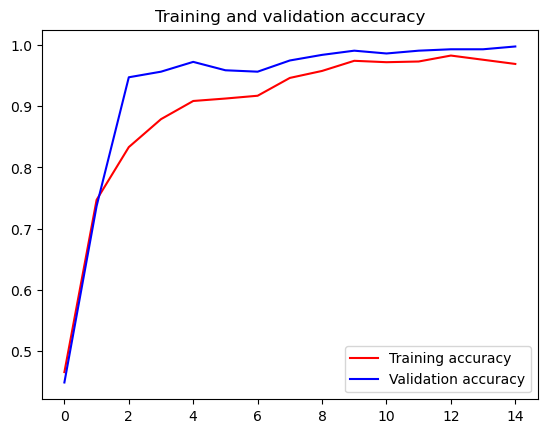

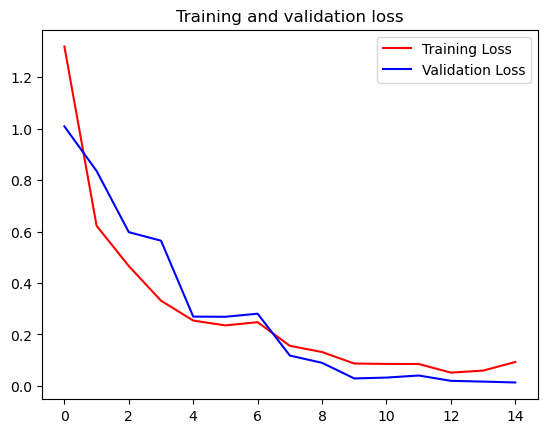

In [11]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

Found 2188 images belonging to 3 classes.
69/69 [==============================] - 7s 95ms/step
Dokładność systemu: 99.82 procent


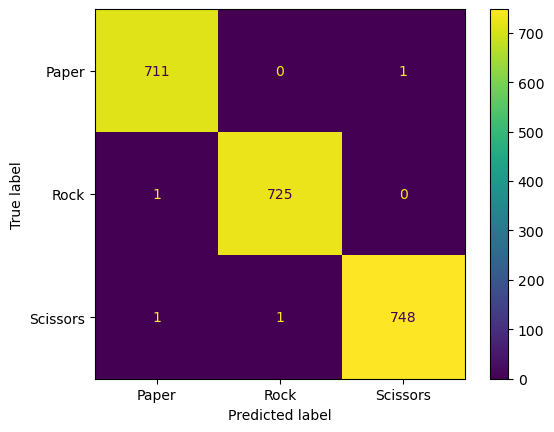

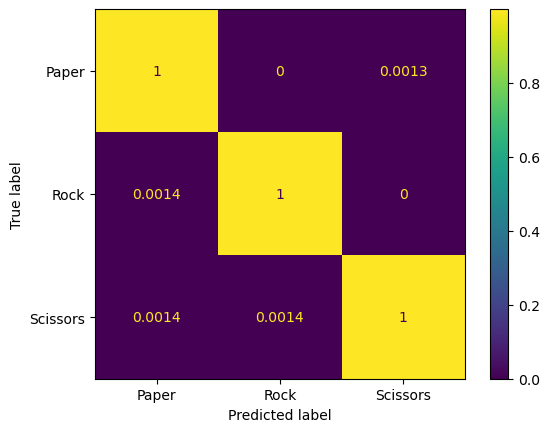

In [21]:
test_data = ImageDataGenerator(rescale = 1.0/255)
test_generator = test_data.flow_from_directory(main_dir,
                                                    target_size=(60, 40), 
                                                   shuffle = False)

probs = model.predict(test_generator)
preds = probs.argmax(axis = -1)
y_test = test_generator.labels

accuracy = metrics.accuracy_score(y_test, preds)
print("Dokładność systemu: %.2f procent" % (accuracy*100))

cm = confusion_matrix(y_test,preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Paper", "Rock", "Scissors"])
cm_norm =confusion_matrix(y_test,preds, normalize='pred')
cm_norm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels = ["Paper", "Rock", "Scissors"])

cm_display.plot()
cm_norm_display.plot()
plt.show()

## Wnioski

> Jak możemy zaobserwować na powyższych wykresach, nasz model po wytrenowaniu osiąga niemalże stuprocentową skuteczność co jest bardzo zadowalającym wynikiem.

> Z macierzy konfuzji nie wynikają wielkie wnioski, bo błędne kategoryzowanie przez model sprowadza się do nikłej ilości przypadków, co może być wynikiem różnego typu czynników jak np. podobieństwa obrazów wynikającego ze zbyt dużego przeskalowania ich na wejściu, czy też po prostu niedostatecznego wyuczenia modelu.

## Dlaczego taka budowa modelu, a nie inna?
1. Pozbycie się drugiej warstwy Conv2D znacząco obniża umiejętności klasyfikacyjne obrazów nie należących do zbioru testowego (filtry nie zostały udoskonalone)
1. Nie używanie funkcji batch normalization obniża późniejsze umiejętności uczenia się modelu. Sam wykres również nam to obrazuje
1. Usunięcie paddingów sprawia, że model w trakcie nauki, traci część danych przy każdej filtracji (tworzeniu mapy cech). W wyniku tego model przy mniejszej liczbe epok uczyłby się zdecydowanie słabiej.
1. Zmniejszenie neuronów warstwy Dense znacząco ogarnicza umiejętności kategoryzacji obiektów.
1. Zwiększenie neuronów nie wpływa znacząco na jakość klasyfikacji modelu. Może conajwyżej troszkę go osłabić ze względu na mniejszą generalizację pewnych zależności.


In [12]:
import numpy as np
from PIL import Image

In [ ]:
#Funkcje używane do wyświetlania obrazów
def pliob(listaobr, ile_k = 1, listatyt = [], wart_dpi = 100, osie = False):
    # wyswietla liste obrazow kolorowych lub s skali szarosci
    rozm_obr = 5
    ile = len(listaobr)
    if len(listatyt) == 0:
        listatyt = [' ']*ile
    ile_w = np.ceil(ile / ile_k).astype(int)
    figsize_k = rozm_obr*ile_k
    figsize_w = rozm_obr*ile_w
    plt.figure(figsize=(figsize_k,figsize_w), dpi = wart_dpi)
    for i in range(0,ile):
        if isinstance(listaobr[i],np.ndarray):
            plt.subplot(ile_w,ile_k,i+1)
            pokaz(listaobr[i], listatyt[i], osie)
    plt.show()
    
def pokaz(im, tytul = "", osie = False):
    if not(osie):
        plt.axis("off") 
    plt.imshow(im)
    plt.title(tytul)

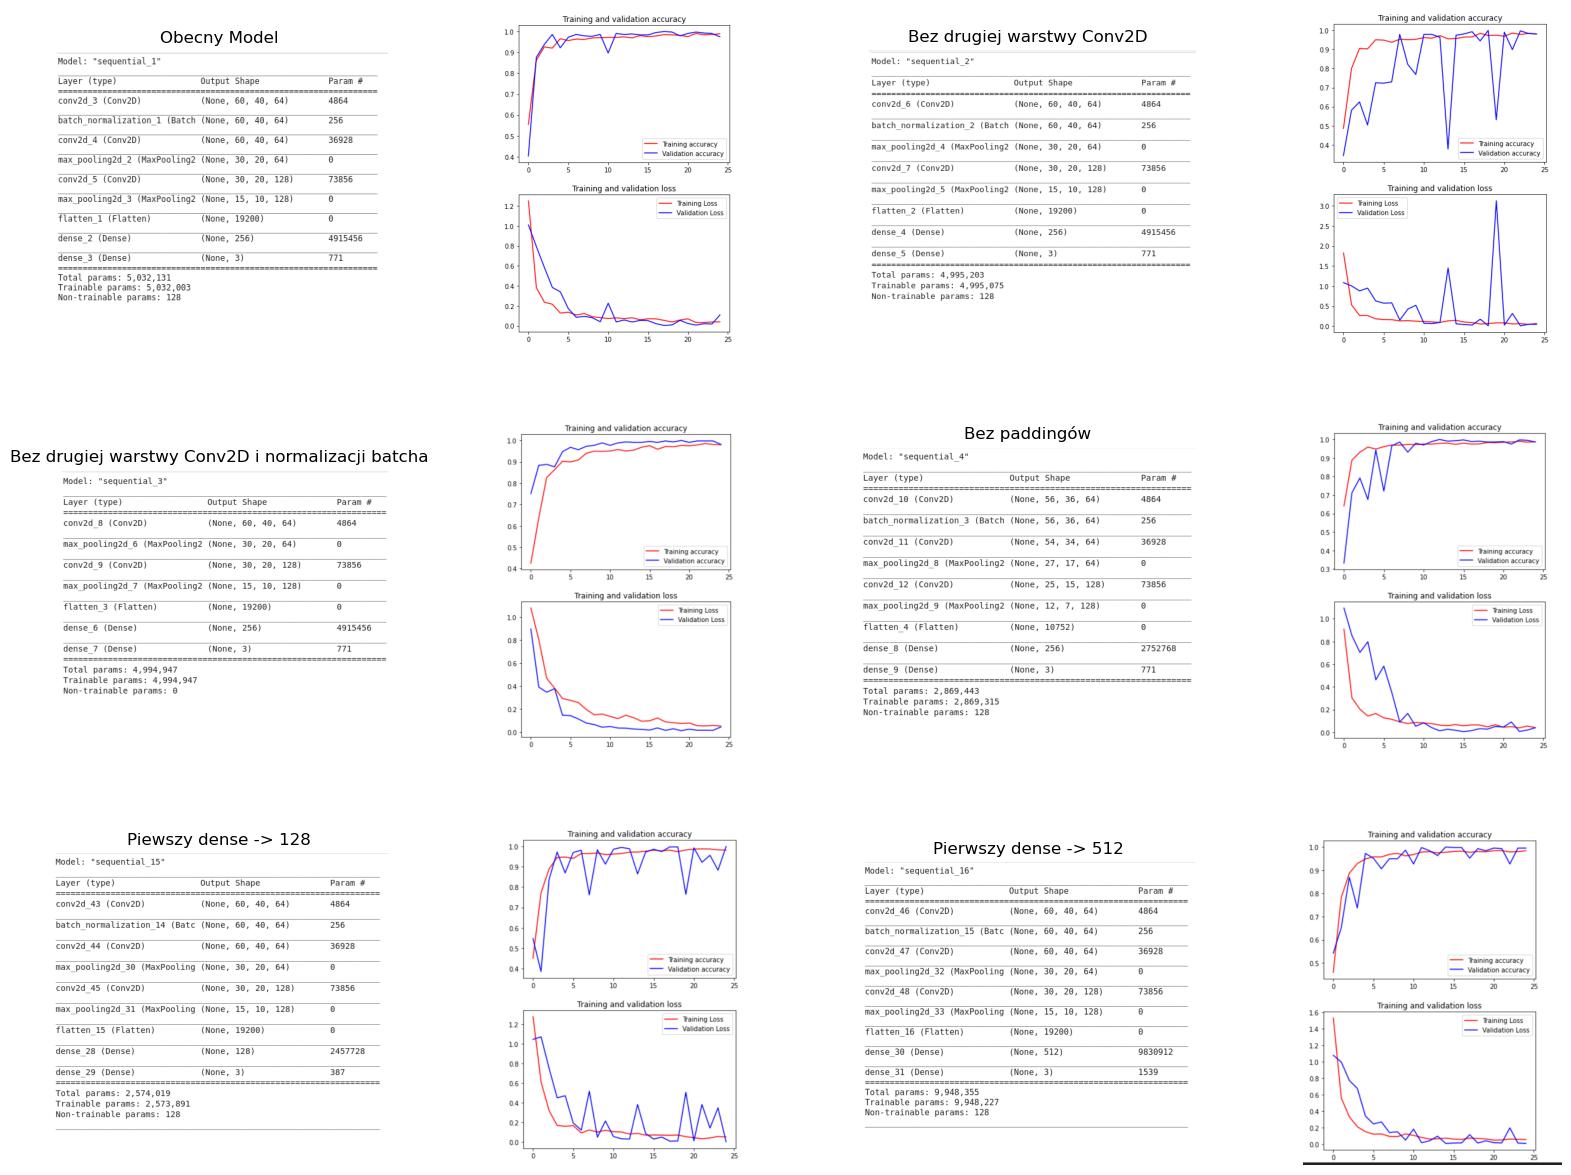

In [43]:
models_dir = PATH + "/data/model"
model_obecny = mpimg.imread(models_dir + "_obecny.png")
model_obecny_plot = mpimg.imread(models_dir + "1plot.png")
model2 = mpimg.imread(models_dir + "2.png")
model2plot = mpimg.imread(models_dir + "2plot.png")
model3 = mpimg.imread(models_dir + "3.png")
model3plot = mpimg.imread(models_dir + "3plot.png")
model4 = mpimg.imread(models_dir + "4.png")
model4plot = mpimg.imread(models_dir + "4plot.png")
model8 = mpimg.imread(models_dir + "8.png")
model8plot = mpimg.imread(models_dir + "8plot.png")
model9 = mpimg.imread(models_dir + "9.png")
model9plot = mpimg.imread(models_dir + "9plot.png")


pliob([model_obecny, model_obecny_plot, model2, model2plot, 
       model3, model3plot, model4, model4plot, 
       model8, model8plot, model9, model9plot], 
      4, 
      ['Obecny Model', "", 'Bez drugiej warstwy Conv2D', '', 
       "Bez drugiej warstwy Conv2D i normalizacji batcha", "","Bez paddingów", "", 
       "Piewszy dense -> 128", "", "Pierwszy dense -> 512", ""])


## Praktyczne zastosowanie modelu do rozpoznawiania obrazów

Etykiety klas:
{'paper': 0, 'rock': 1, 'scissors': 2} 
 

Papier, Wynik klasyfikacji: 

1/1 [==============================] - 0s 170ms/step
[[1. 0. 0.]] 
 

Kamień, Wynik klasyfikacji: 

1/1 [==============================] - 0s 53ms/step
[[0. 1. 0.]] 
 

Nożyce, Wynik klasyfikacji: 

1/1 [==============================] - 0s 70ms/step
[[0. 0. 1.]] 
 



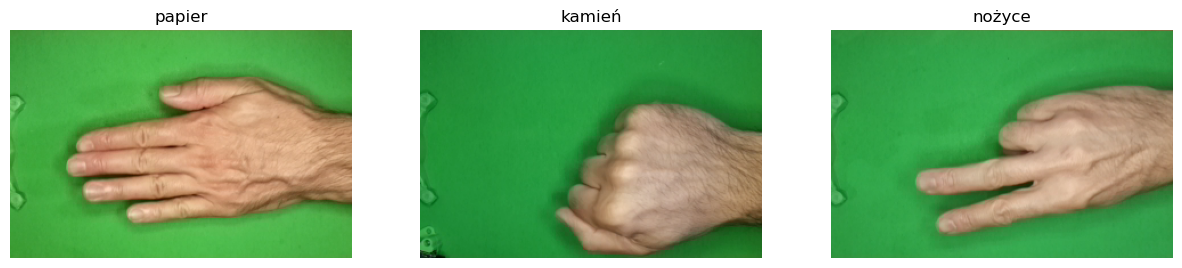

In [136]:
print("Etykiety klas:")
print(train_generator.class_indices , '\n' , '\n')


image = Image.open(PATH + "/rps-cv-images/paper/04l5I8TqdzF9WDMJ.png")
image_new = image.resize((40,60))
image_array = np.array(image_new)
holder = []
holder.append(image_array)
holder = np.array(holder)
print("Papier, Wynik klasyfikacji:", '\n')
print(model.predict(holder), '\n', '\n')
image1np = mpimg.imread(PATH + "/rps-cv-images/paper/04l5I8TqdzF9WDMJ.png")

image3 = Image.open(PATH + "/rps-cv-images/rock/00nKV8oHuTGi20gq.png")
image_new3 = image3.resize((40,60))
image_array3 = np.array(image_new3)
holder3 = []
holder3.append(image_array3)
holder3 = np.array(holder3)
print("Kamień, Wynik klasyfikacji:", '\n')
print(model.predict(holder3), '\n', '\n')
image3np = mpimg.imread(PATH + "/rps-cv-images/rock/00nKV8oHuTGi20gq.png")

image2 = Image.open(PATH + "/rps-cv-images/scissors/0657zSfiTYzP2jrl.png")
image_new2 = image2.resize((40,60))
image_array2 = np.array(image_new2)
holder2 = []
holder2.append(image_array2)
holder2 = np.array(holder2)
print("Nożyce, Wynik klasyfikacji:",'\n')
print(model.predict(holder2),'\n', '\n')
image2np = mpimg.imread(PATH + "/rps-cv-images/scissors/0657zSfiTYzP2jrl.png")

pliob([image1np, image3np, image2np], 3, ['papier', 'kamień', 'nożyce'])


## Źródła:
* Zbiór danych: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?datasetId=107582&sortBy=voteCount
* Kod inspiracyjny: https://www.kaggle.com/code/anurag629/rockpaperscissors-accuracy-99-detailed-explanation
* Opis działania CNN: https://youtu.be/HGwBXDKFk9I
* Opis ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* Opis działania padding: https://youtu.be/PGBop7Ka9AU
* Opis normalizacji batchu (BatchNormalization): https://youtu.be/yXOMHOpbon8
* Opis ReduceLROnPlateau: https://keras.io/api/callbacks/reduce_lr_on_plateau/
* Opis funkcji straty: https://gombru.github.io/2018/05/23/cross_entropy_loss/
* Opis optymizatorów w sieci CNN: https://www.youtube.com/watch?v=JhQqquVeCE0